In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

ml_data = pd.read_csv(r"C:/Users/Elias/Final Project/Cleaned output data files/ml_data.csv")
print(f" Loaded dataset with {ml_data.shape[0]} samples and {ml_data.shape[1]} columns")

# Separate features and target
X = ml_data.drop('LBW_Rate', axis=1)
y = ml_data['LBW_Rate']
feature_names = list(X.columns)

print(f"\n Target: LBW_Rate ({y.min():.2f}% to {y.max():.2f}%)")
print(f" Features ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"   {i}. {feat}")

# Split data
print("\n Splitting data (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"   • Training set: {X_train.shape[0]} samples")
print(f"   • Test set: {X_test.shape[0]} samples")

 Loaded dataset with 243 samples and 6 columns

 Target: LBW_Rate (0.00% to 30.46%)
 Features (5):
   1. health_insurance_coverage_pop
   2. poverty_rate
   3. avg_diesel_pm
   4. diesel_poverty_interaction
   5. avg_traffic_pct

 Splitting data (80% train, 20% test)...
   • Training set: 194 samples
   • Test set: 49 samples


In [11]:
# ==================== MODEL 1: BASELINE - LINEAR REGRESSION ====================
print("MODEL 1: BASELINE - LINEAR REGRESSION")

X_train_baseline = X_train[['health_insurance_coverage_pop']]
X_test_baseline = X_test[['health_insurance_coverage_pop']]

baseline_model = LinearRegression()
baseline_model.fit(X_train_baseline, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test_baseline)

# Calculate metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
cv_scores_baseline = cross_val_score(baseline_model, X_train_baseline, y_train, cv=5, scoring='r2')
cv_mean_baseline = cv_scores_baseline.mean()
cv_std_baseline = cv_scores_baseline.std()

print("\n✅ Baseline Model Results:")
print(f"   • R² Score: {r2_baseline:.4f}")
print(f"   • MAE: {mae_baseline:.4f} percentage points")
print(f"   • RMSE: {rmse_baseline:.4f} percentage points")
print(f"   • 5-Fold CV R²: {cv_mean_baseline:.4f} (±{cv_std_baseline:.4f})")

# Save baseline model results
print("\nSaving baseline model results...")

# 1. Save predictions
baseline_predictions = pd.DataFrame({
    'Actual_LBW_Rate': y_test.values,
    'Predicted_LBW_Rate': y_pred_baseline,
    'Residual': y_test.values - y_pred_baseline,
    'Insurance_Coverage': X_test_baseline.values.flatten()
})
baseline_predictions.to_csv('baseline_model_predictions.csv', index=False)
print("  Predictions saved to 'baseline_model_predictions.csv'")

# 2. Save metrics to CSV
baseline_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (percentage points)', 'RMSE (percentage points)', 
               '5-Fold CV R² Mean', '5-Fold CV R² Std'],
    'Value': [r2_baseline, mae_baseline, rmse_baseline, cv_mean_baseline, cv_std_baseline]
})
baseline_metrics.to_csv('baseline_model_metrics.csv', index=False)
print("  Metrics saved to 'baseline_model_metrics.csv'")

# 3. Save model coefficients
baseline_coefficients = pd.DataFrame({
    'Feature': ['Intercept', 'health_insurance_coverage_pop'],
    'Coefficient': [baseline_model.intercept_, baseline_model.coef_[0]],
    'Interpretation': [
        'Base LBW Rate when insurance is 0%',
        f'Change in LBW Rate per 1% increase in insurance (negative = beneficial)'
    ]
})
baseline_coefficients.to_csv('baseline_model_coefficients.csv', index=False)
print("   Coefficients saved to 'baseline_model_coefficients.csv'")

# 4. Save visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_baseline, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[0].set_xlabel('Actual LBW Rate (%)')
axes[0].set_ylabel('Predicted LBW Rate (%)')
axes[0].set_title(f'Baseline Model (R² = {r2_baseline:.3f})')
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_baseline
axes[1].scatter(y_pred_baseline, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_model_visualization.png', dpi=300, bbox_inches='tight')
plt.close()
print("  Visualization saved to 'baseline_model_visualization.png'")

MODEL 1: BASELINE - LINEAR REGRESSION

✅ Baseline Model Results:
   • R² Score: 0.1122
   • MAE: 3.0532 percentage points
   • RMSE: 5.1778 percentage points
   • 5-Fold CV R²: -0.0151 (±0.3511)

Saving baseline model results...
  Predictions saved to 'baseline_model_predictions.csv'
  Metrics saved to 'baseline_model_metrics.csv'
   Coefficients saved to 'baseline_model_coefficients.csv'
  Visualization saved to 'baseline_model_visualization.png'


In [12]:
# ==================== MODEL 2: RANDOM FOREST REGRESSOR ====================
print("MODEL 2: RANDOM FOREST REGRESSOR")

# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)

rf_grid.fit(X_train, y_train)

# Best model
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Calculate metrics
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
cv_scores_rf = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')
cv_mean_rf = cv_scores_rf.mean()
cv_std_rf = cv_scores_rf.std()

# Feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_,
    'Percent': (rf_best.feature_importances_ * 100).round(2),
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Importance', ascending=False)

print("\n Random Forest Results:")
print(f"   • Best Parameters: {rf_grid.best_params_}")
print(f"   • R² Score: {r2_rf:.4f}")
print(f"   • Improvement over baseline: +{r2_rf - r2_baseline:.4f} R²")

# Save Random Forest results
print("\n Saving Random Forest model results...")

# 1. Save predictions
rf_predictions = pd.DataFrame({
    'Actual_LBW_Rate': y_test.values,
    'Predicted_LBW_Rate': y_pred_rf,
    'Residual': y_test.values - y_pred_rf
})
# Add feature values
for feature in feature_names:
    rf_predictions[feature] = X_test[feature].values
rf_predictions.to_csv('random_forest_predictions.csv', index=False)
print("   Predictions saved to 'random_forest_predictions.csv'")

# 2. Save metrics
rf_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (percentage points)', 'RMSE (percentage points)', 
               '5-Fold CV R² Mean', '5-Fold CV R² Std', 'Improvement over Baseline R²'],
    'Value': [r2_rf, mae_rf, rmse_rf, cv_mean_rf, cv_std_rf, r2_rf - r2_baseline]
})
rf_metrics.to_csv('random_forest_metrics.csv', index=False)
print("  Metrics saved to 'random_forest_metrics.csv'")

# 3. Save hyperparameters
rf_params_df = pd.DataFrame([rf_grid.best_params_])
rf_params_df.to_csv('random_forest_parameters.csv', index=False)
print("  Hyperparameters saved to 'random_forest_parameters.csv'")

# 4. Save feature importance
rf_importance.to_csv('random_forest_feature_importance.csv', index=False)
print(" Feature importance saved to 'random_forest_feature_importance.csv'")

# 5. Save visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Feature importance
axes[0].barh(rf_importance['Feature'], rf_importance['Percent'])
axes[0].set_xlabel('Importance (%)')
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()

# Actual vs Predicted
axes[1].scatter(y_test, y_pred_rf, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1].set_xlabel('Actual LBW Rate (%)')
axes[1].set_ylabel('Predicted LBW Rate (%)')
axes[1].set_title(f'Random Forest (R² = {r2_rf:.3f})')
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_rf
axes[2].scatter(y_pred_rf, residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('random_forest_visualization.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Visualization saved to 'random_forest_visualization.png'")

MODEL 2: RANDOM FOREST REGRESSOR

 Random Forest Results:
   • Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
   • R² Score: 0.3210
   • Improvement over baseline: +0.2088 R²

 Saving Random Forest model results...
   Predictions saved to 'random_forest_predictions.csv'
  Metrics saved to 'random_forest_metrics.csv'
  Hyperparameters saved to 'random_forest_parameters.csv'
 Feature importance saved to 'random_forest_feature_importance.csv'
 Visualization saved to 'random_forest_visualization.png'


In [13]:
# ==================== MODEL 3: XGBOOST REGRESSOR ====================

print("MODEL 3: XGBOOST REGRESSOR")

print("Training XGBoost Model (5 features)...")

# Hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1)

xgb_grid.fit(X_train, y_train)

# Best model
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

# Calculate metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
cv_scores_xgb = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='r2')
cv_mean_xgb = cv_scores_xgb.mean()
cv_std_xgb = cv_scores_xgb.std()

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_best.feature_importances_,
    'Percent': (xgb_best.feature_importances_ * 100).round(2),
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Importance', ascending=False)

print("\n XGBoost Results:")
print(f"   • Best Parameters: {xgb_grid.best_params_}")
print(f"   • R² Score: {r2_xgb:.4f}")
print(f"   • Improvement over baseline: +{r2_xgb - r2_baseline:.4f} R²")

# Save XGBoost results
print("\n Saving XGBoost model results...")

# 1. Save predictions
xgb_predictions = pd.DataFrame({
    'Actual_LBW_Rate': y_test.values,
    'Predicted_LBW_Rate': y_pred_xgb,
    'Residual': y_test.values - y_pred_xgb
})
# Add feature values
for feature in feature_names:
    xgb_predictions[feature] = X_test[feature].values
xgb_predictions.to_csv('xgboost_predictions.csv', index=False)
print(" Predictions saved to 'xgboost_predictions.csv'")

# 2. Save metrics
xgb_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (percentage points)', 'RMSE (percentage points)', 
               '5-Fold CV R² Mean', '5-Fold CV R² Std', 'Improvement over Baseline R²'],
    'Value': [r2_xgb, mae_xgb, rmse_xgb, cv_mean_xgb, cv_std_xgb, r2_xgb - r2_baseline]
})
xgb_metrics.to_csv('xgboost_metrics.csv', index=False)
print("  Metrics saved to 'xgboost_metrics.csv'")

# 3. Save hyperparameters
xgb_params_df = pd.DataFrame([xgb_grid.best_params_])
xgb_params_df.to_csv('xgboost_parameters.csv', index=False)
print(" Hyperparameters saved to 'xgboost_parameters.csv'")

# 4. Save feature importance
xgb_importance.to_csv('xgboost_feature_importance.csv', index=False)
print(" Feature importance saved to 'xgboost_feature_importance.csv'")

# 5. Save visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Feature importance
axes[0].barh(xgb_importance['Feature'], xgb_importance['Percent'])
axes[0].set_xlabel('Importance (%)')
axes[0].set_title('XGBoost Feature Importance')
axes[0].invert_yaxis()

# Actual vs Predicted
axes[1].scatter(y_test, y_pred_xgb, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1].set_xlabel('Actual LBW Rate (%)')
axes[1].set_ylabel('Predicted LBW Rate (%)')
axes[1].set_title(f'XGBoost (R² = {r2_xgb:.3f})')
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_xgb
axes[2].scatter(y_pred_xgb, residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgboost_visualization.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Visualization saved to 'xgboost_visualization.png'")

MODEL 3: XGBOOST REGRESSOR
Training XGBoost Model (5 features)...

 XGBoost Results:
   • Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
   • R² Score: 0.2847
   • Improvement over baseline: +0.1725 R²

 Saving XGBoost model results...
 Predictions saved to 'xgboost_predictions.csv'
  Metrics saved to 'xgboost_metrics.csv'
 Hyperparameters saved to 'xgboost_parameters.csv'
 Feature importance saved to 'xgboost_feature_importance.csv'
 Visualization saved to 'xgboost_visualization.png'


In [14]:
# ==================== MODEL 4: GRADIENT BOOSTING REGRESSOR ====================
print("MODEL 4: GRADIENT BOOSTING REGRESSOR")

# Hyperparameter tuning
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='r2', n_jobs=-1)

gb_grid.fit(X_train, y_train)

# Best model
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)

# Calculate metrics
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
cv_scores_gb = cross_val_score(gb_best, X_train, y_train, cv=5, scoring='r2')
cv_mean_gb = cv_scores_gb.mean()
cv_std_gb = cv_scores_gb.std()

# Feature importance
gb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_best.feature_importances_,
    'Percent': (gb_best.feature_importances_ * 100).round(2),
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Importance', ascending=False)

print("\n Gradient Boosting Results:")
print(f"   • Best Parameters: {gb_grid.best_params_}")
print(f"   • R² Score: {r2_gb:.4f}")
print(f"   • Improvement over baseline: +{r2_gb - r2_baseline:.4f} R²")

# Save Gradient Boosting results
print("\n Saving Gradient Boosting model results...")

# 1. Save predictions
gb_predictions = pd.DataFrame({
    'Actual_LBW_Rate': y_test.values,
    'Predicted_LBW_Rate': y_pred_gb,
    'Residual': y_test.values - y_pred_gb
})
# Add feature values
for feature in feature_names:
    gb_predictions[feature] = X_test[feature].values
gb_predictions.to_csv('gradient_boosting_predictions.csv', index=False)
print(" Predictions saved to 'gradient_boosting_predictions.csv'")

# 2. Save metrics
gb_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (percentage points)', 'RMSE (percentage points)', 
               '5-Fold CV R² Mean', '5-Fold CV R² Std', 'Improvement over Baseline R²'],
    'Value': [r2_gb, mae_gb, rmse_gb, cv_mean_gb, cv_std_gb, r2_gb - r2_baseline]
})
gb_metrics.to_csv('gradient_boosting_metrics.csv', index=False)
print(" Metrics saved to 'gradient_boosting_metrics.csv'")

# 3. Save hyperparameters
gb_params_df = pd.DataFrame([gb_grid.best_params_])
gb_params_df.to_csv('gradient_boosting_parameters.csv', index=False)
print(" Hyperparameters saved to 'gradient_boosting_parameters.csv'")

# 4. Save feature importance
gb_importance.to_csv('gradient_boosting_feature_importance.csv', index=False)
print(" Feature importance saved to 'gradient_boosting_feature_importance.csv'")

# 5. Save visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Feature importance
axes[0].barh(gb_importance['Feature'], gb_importance['Percent'])
axes[0].set_xlabel('Importance (%)')
axes[0].set_title('Gradient Boosting Feature Importance')
axes[0].invert_yaxis()

# Actual vs Predicted
axes[1].scatter(y_test, y_pred_gb, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1].set_xlabel('Actual LBW Rate (%)')
axes[1].set_ylabel('Predicted LBW Rate (%)')
axes[1].set_title(f'Gradient Boosting (R² = {r2_gb:.3f})')
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_gb
axes[2].scatter(y_pred_gb, residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_boosting_visualization.png', dpi=300, bbox_inches='tight')
plt.close()
print(" Visualization saved to 'gradient_boosting_visualization.png'")

MODEL 4: GRADIENT BOOSTING REGRESSOR

 Gradient Boosting Results:
   • Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
   • R² Score: 0.2353
   • Improvement over baseline: +0.1230 R²

 Saving Gradient Boosting model results...
 Predictions saved to 'gradient_boosting_predictions.csv'
 Metrics saved to 'gradient_boosting_metrics.csv'
 Hyperparameters saved to 'gradient_boosting_parameters.csv'
 Feature importance saved to 'gradient_boosting_feature_importance.csv'
 Visualization saved to 'gradient_boosting_visualization.png'


FINAL MODEL COMPARISON & SUMMARY

 MODEL PERFORMANCE COMPARISON:
                    Model  R²_Score   MAE_pp  Improvement_vs_Baseline  Is_Best
Baseline (Insurance only)  0.112240 3.053157                 0.000000    False
            Random Forest  0.321012 2.401334                 0.208771     True
                  XGBoost  0.284729 2.518877                 0.172489    False
        Gradient Boosting  0.235289 2.391237                 0.123049    False

 BEST MODEL: Random Forest
   • R² Score: 0.3210
   • Improvement over baseline: +0.2088 R²
   • Variance explained: 32.1%

 FEATURE IMPORTANCE COMPARISON ACROSS MODELS:
                      Feature  Random_Forest_Importance_%  XGBoost_Importance_%  Gradient_Boosting_Importance_%  Average_Importance_%  Rank_by_Average
health_insurance_coverage_pop                       61.76             36.509998                           76.25                 58.17                1
                 poverty_rate                       21.79          

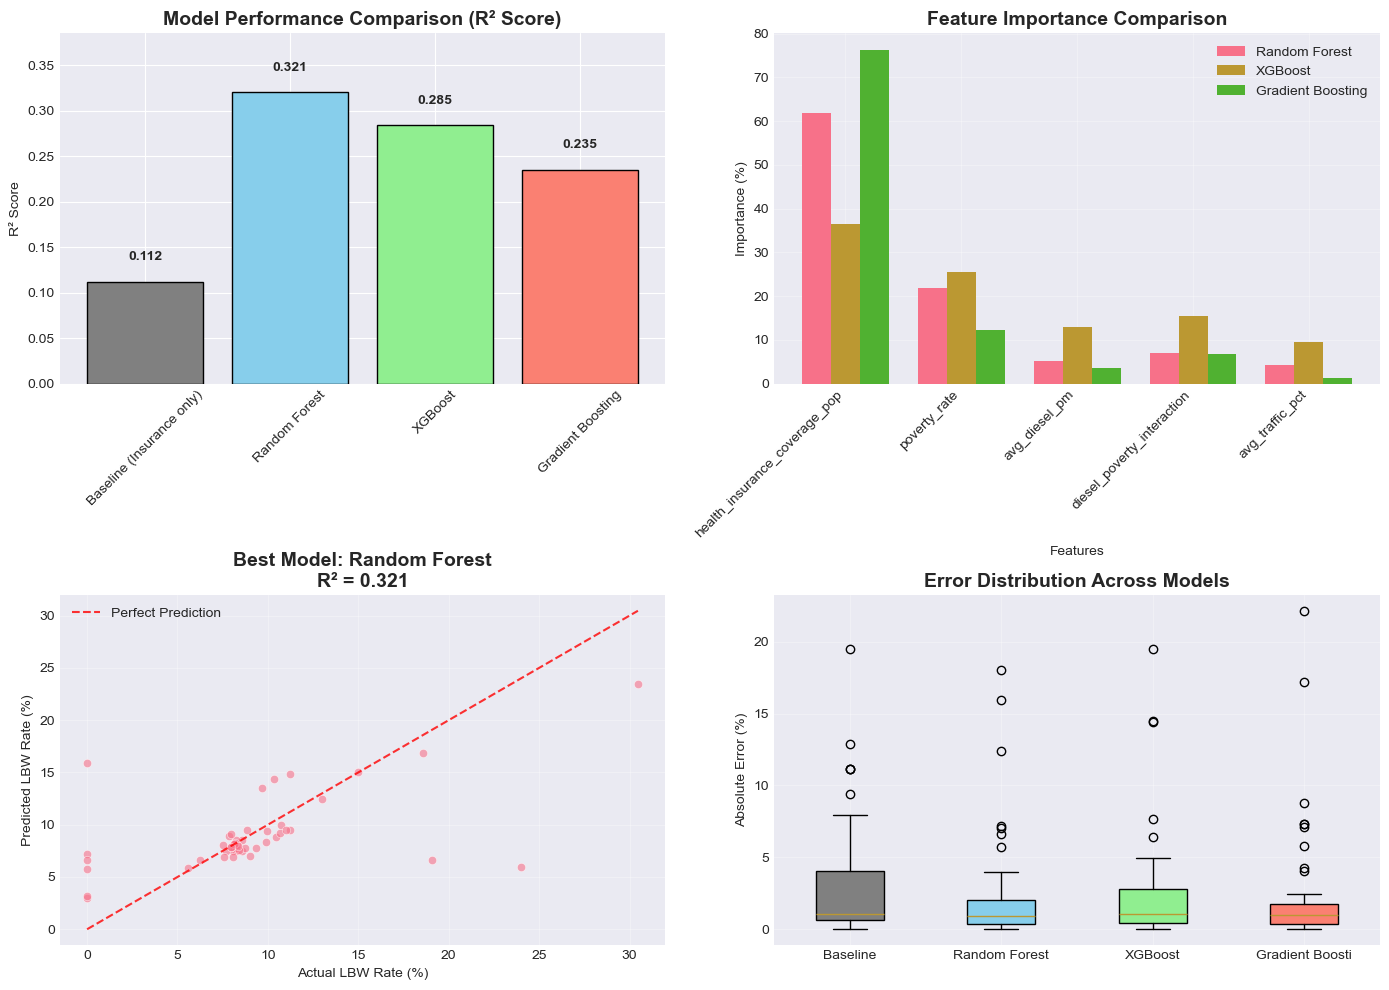

  Final visualization saved to 'final_model_comparison.png'


In [15]:
# ==================== FINAL COMPARISON & SUMMARY ====================

print("FINAL MODEL COMPARISON & SUMMARY")

model_comparison = pd.DataFrame({
    'Model': ['Baseline (Insurance only)', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'R²_Score': [r2_baseline, r2_rf, r2_xgb, r2_gb],
    'MAE_pp': [mae_baseline, mae_rf, mae_xgb, mae_gb],
    'RMSE_pp': [rmse_baseline, rmse_rf, rmse_xgb, rmse_gb],
    'CV_R²_Mean': [cv_mean_baseline, cv_mean_rf, cv_mean_xgb, cv_mean_gb],
    'CV_R²_Std': [cv_std_baseline, cv_std_rf, cv_std_xgb, cv_std_gb],
    'Improvement_vs_Baseline': [0, r2_rf - r2_baseline, r2_xgb - r2_baseline, r2_gb - r2_baseline],
    'Best_Parameters': [
        'LinearRegression()',
        str(rf_grid.best_params_),
        str(xgb_grid.best_params_),
        str(gb_grid.best_params_)
    ]
})

# Determine best model
best_idx = model_comparison['R²_Score'].idxmax()
model_comparison['Is_Best'] = False
model_comparison.loc[best_idx, 'Is_Best'] = True
best_model = model_comparison.loc[best_idx, 'Model']
best_r2 = model_comparison.loc[best_idx, 'R²_Score']

print("\n MODEL PERFORMANCE COMPARISON:")

print(model_comparison[['Model', 'R²_Score', 'MAE_pp', 'Improvement_vs_Baseline', 'Is_Best']].to_string(index=False))

print(f"\n BEST MODEL: {best_model}")
print(f"   • R² Score: {best_r2:.4f}")
print(f"   • Improvement over baseline: +{best_r2 - r2_baseline:.4f} R²")
print(f"   • Variance explained: {best_r2*100:.1f}%")

# Feature importance comparison
print("\n FEATURE IMPORTANCE COMPARISON ACROSS MODELS:")

feature_comparison = pd.DataFrame({'Feature': feature_names})
feature_importance_dfs = {
    'Random_Forest': rf_importance,
    'XGBoost': xgb_importance,
    'Gradient_Boosting': gb_importance
}

for model_name, imp_df in feature_importance_dfs.items():
    feature_comparison[f'{model_name}_Importance_%'] = imp_df.set_index('Feature').loc[feature_names, 'Percent'].values

# Calculate average importance
feature_comparison['Average_Importance_%'] = feature_comparison[[
    'Random_Forest_Importance_%', 
    'XGBoost_Importance_%', 
    'Gradient_Boosting_Importance_%'
]].mean(axis=1)

feature_comparison['Rank_by_Average'] = feature_comparison['Average_Importance_%'].rank(ascending=False).astype(int)
feature_comparison = feature_comparison.sort_values('Average_Importance_%', ascending=False)

print(feature_comparison.round(2).to_string(index=False))

# Save all comparison files
print("\n Saving final comparison files...")

# 1. Save model comparison
model_comparison.to_csv('model_comparison_summary.csv', index=False)
print(" Model comparison saved to 'model_comparison_summary.csv'")

# 2. Save feature importance comparison
feature_comparison.to_csv('feature_importance_comparison.csv', index=False)
print(" Feature importance comparison saved to 'feature_importance_comparison.csv'")

# 3. Create combined predictions file (all models)
all_predictions = pd.DataFrame({
    'Actual_LBW_Rate': y_test.values,
    'Baseline_Prediction': y_pred_baseline,
    'Random_Forest_Prediction': y_pred_rf,
    'XGBoost_Prediction': y_pred_xgb,
    'Gradient_Boosting_Prediction': y_pred_gb
})

# Add feature values
for feature in feature_names:
    all_predictions[feature] = X_test[feature].values

all_predictions.to_csv('all_model_predictions.csv', index=False)
print("  All model predictions saved to 'all_model_predictions.csv'")

# 4. Create final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Model Performance Comparison
colors = ['gray', 'skyblue', 'lightgreen', 'salmon']
bars = axes[0, 0].bar(model_comparison['Model'], model_comparison['R²_Score'], 
                     color=colors, edgecolor='black')
axes[0, 0].set_title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_ylim([0, max(model_comparison['R²_Score']) * 1.2])
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (bar, score) in enumerate(zip(bars, model_comparison['R²_Score'])):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, score + 0.02, 
                   f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Feature Importance Comparison
x = np.arange(len(feature_names))
width = 0.25
axes[0, 1].bar(x - width, rf_importance.set_index('Feature').loc[feature_names, 'Percent'], 
              width, label='Random Forest')
axes[0, 1].bar(x, xgb_importance.set_index('Feature').loc[feature_names, 'Percent'], 
              width, label='XGBoost')
axes[0, 1].bar(x + width, gb_importance.set_index('Feature').loc[feature_names, 'Percent'], 
              width, label='Gradient Boosting')
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Importance (%)')
axes[0, 1].set_title('Feature Importance Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(feature_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Best Model: Actual vs Predicted
if best_model == 'Baseline (Insurance only)':
    best_pred = y_pred_baseline
elif best_model == 'Random Forest':
    best_pred = y_pred_rf
elif best_model == 'XGBoost':
    best_pred = y_pred_xgb
else:
    best_pred = y_pred_gb

axes[1, 0].scatter(y_test, best_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', alpha=0.8, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual LBW Rate (%)')
axes[1, 0].set_ylabel('Predicted LBW Rate (%)')
axes[1, 0].set_title(f'Best Model: {best_model}\nR² = {best_r2:.3f}', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Error Distribution Comparison
errors = pd.DataFrame({
    'Baseline': abs(y_test - y_pred_baseline),
    'Random Forest': abs(y_test - y_pred_rf),
    'XGBoost': abs(y_test - y_pred_xgb),
    'Gradient Boosting': abs(y_test - y_pred_gb)
})

box = axes[1, 1].boxplot([errors[col] for col in errors.columns], 
                        labels=[name[:15] for name in errors.columns], 
                        patch_artist=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Absolute Error (%)')
axes[1, 1].set_title('Error Distribution Across Models', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("  Final visualization saved to 'final_model_comparison.png'")

# 5. Create comprehensive results summary CSV
results_summary = pd.DataFrame({
    'Analysis_Step': ['Data Overview', 'Model Building', 'Performance', 'Key Findings'],
    'Details': [
        f'{X.shape[0]} ZIP codes × {X.shape[1]} features; Target: LBW_Rate ({y.min():.2f}% to {y.max():.2f}%)',
        f'4 models built: Baseline (Insurance only), Random Forest, XGBoost, Gradient Boosting',
        f'Best Model: {best_model} with R² = {best_r2:.4f} (Improvement: +{best_r2 - r2_baseline:.4f})',
        f'Primary predictor: {feature_comparison.iloc[0]["Feature"]} ({feature_comparison.iloc[0]["Average_Importance_%"]:.1f}% avg importance)'
    ]
})

results_summary.to_csv('results_summary.csv', index=False)